In [54]:
import openpyxl
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import keras
from tensorflow.keras.optimizers import Adam, RMSprop 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [55]:
Xray_df = pd.read_csv(r'C:\Users\jenic\Downloads\archive\Data_Entry_2017.csv')

Xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [56]:
pattern = os.path.join('.', 'data', 'images*', '*.png')

image_paths = glob.glob(pattern)

all_image_paths = {os.path.basename(x): x for x in image_paths}

for dirname, _, filenames in os.walk(r'C:\Users\jenic\data sci\resized'):
    for filename in filenames:
        if filename.endswith('.png'):
            all_image_paths[filename] = os.path.join(dirname, filename)

print(len(all_image_paths))

112120


In [57]:
label_counts = Xray_df['Finding Labels'].value_counts()

In [58]:
Xray_df['Finding Labels'] = Xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*Xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1:
        Xray_df[c_label] = Xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
Xray_df.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
94499,00024261_000.png,,0,24261,38,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83739,00020563_000.png,,0,20563,56,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18417,00004893_071.png,,71,4893,33,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if Xray_df[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(Xray_df[c_label].sum())) for c_label in all_labels])

Clean Labels (13) [('Atelectasis', 11559), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2303), ('Effusion', 13317), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19894), ('Mass', 5782), ('Nodule', 6331), ('Pleural_Thickening', 3385), ('Pneumonia', 1431), ('Pneumothorax', 5302)]


In [60]:
Xray_df['disease_vec'] = Xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [61]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(Xray_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = Xray_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 84090 validation 28030


In [62]:
valid_df['newLabel'] = valid_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
train_df['newLabel'] = train_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)

In [63]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (128, 128)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [64]:
Xray_df.to_excel('Xray_df.xlsx',index=False)

In [65]:
data_path = r'C:\Users\jenic\data sci\resized'
labels_path = "Xray_df.xlsx"

df = pd.read_excel(labels_path)

In [66]:
Xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,disease_vec
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
3,00000002_000.png,,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [67]:
train_df['path'] = train_df['Image Index'].map(all_image_paths.get)
valid_df['path'] = valid_df['Image Index'].map(all_image_paths.get)

In [68]:
train_gen = core_idg.flow_from_dataframe(dataframe=train_df, 
                             directory=None,
                             x_col = 'path',
                            y_col = 'newLabel', 
                             class_mode = 'categorical',
                            classes = all_labels,
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 32)

val_generator = core_idg.flow_from_dataframe(dataframe=valid_df, 
                             directory=None,
                             x_col = 'path',
                            y_col = 'newLabel', 
                             class_mode = 'categorical',
                            classes = all_labels,
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 32)

train_X, train_Y = next(core_idg.flow_from_dataframe(dataframe=train_df, 
                             directory=None,
                             x_col = 'path',
                            y_col = 'newLabel', 
                             class_mode = 'categorical',
                            classes = all_labels,
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 1024))

test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=valid_df, 
                             directory=None,
                             x_col = 'path',
                            y_col = 'newLabel', 
                             class_mode = 'categorical',
                            classes = all_labels,
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 1024))


Found 38736 validated image filenames belonging to 13 classes.
Found 12913 validated image filenames belonging to 13 classes.
Found 38736 validated image filenames belonging to 13 classes.
Found 12913 validated image filenames belonging to 13 classes.


In [69]:
t_x, t_y = next(train_gen)

In [70]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Activation
from keras.models import Sequential
from keras import optimizers, callbacks, regularizers

In [83]:
base_mobilenet_model = MobileNet(input_shape =  t_x.shape[1:], 
                                 include_top = False, weights = None)
model = Sequential()
model.add(base_mobilenet_model)
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation = 'sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(len(all_labels), activation = 'sigmoid'))

In [75]:
optimizers_list = [('adam', optimizers.Adam()) 
                  ]

In [77]:
model.compile(optimizer = optimizer[1], loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
    
history = model.fit(train_gen, batch_size=1211,
                    validation_data = (test_X, test_Y), epochs = 3, )

Epoch 1/3
1211/1211 ━━━━━━━━━━━━━━━━━━━━ 1005s 817ms/step - binary_accuracy: 0.8802 - loss: 0.3175 - mae: 0.1860 - val_binary_accuracy: 0.8794 - val_loss: 0.3084 - val_mae: 0.1804
Epoch 2/3
1211/1211 ━━━━━━━━━━━━━━━━━━━━ 961s 793ms/step - binary_accuracy: 0.8818 - loss: 0.3107 - mae: 0.1823 - val_binary_accuracy: 0.8779 - val_loss: 0.3108 - val_mae: 0.1861
Epoch 3/3
1211/1211 ━━━━━━━━━━━━━━━━━━━━ 949s 783ms/step - binary_accuracy: 0.8827 - loss: 0.3066 - mae: 0.1806 - val_binary_accuracy: 0.8796 - val_loss: 0.3078 - val_mae: 0.1763


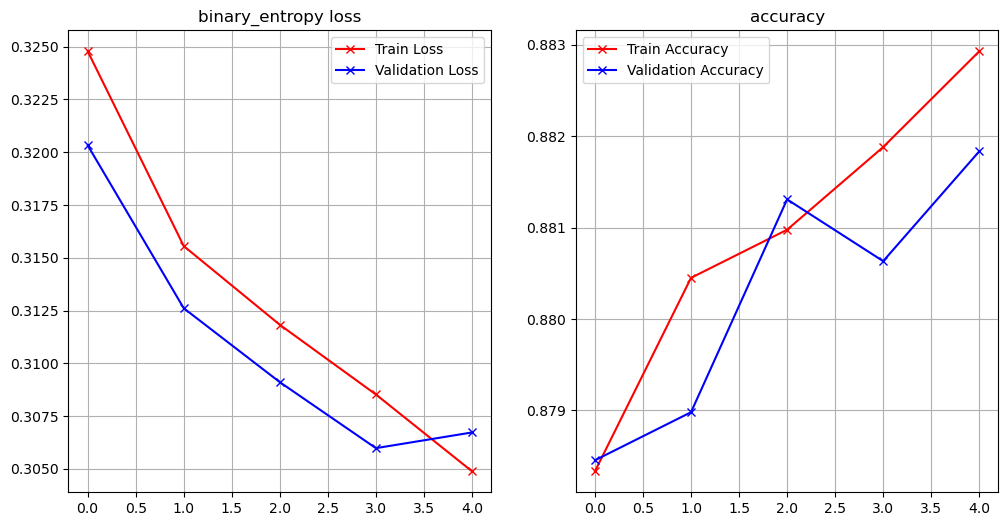

In [90]:
def plot_loss_accuracy(history):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history["loss"],'r-x', label="Train Loss")
    ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
    ax.legend()
    ax.set_title('binary_entropy loss')
    ax.grid(True)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history["binary_accuracy"],'r-x', label="Train Accuracy")
    ax.plot(history.history["val_binary_accuracy"],'b-x', label="Validation Accuracy")
    ax.legend()
    ax.set_title('accuracy')
    ax.grid(True)


plot_loss_accuracy(history)

In [ ]:
The accuracy above shows a fluctuating value due to the minimal number of epoch and data used. However, the optimizer used(Adam) and the incorporation of 
MobileNet made it easier to create hidden layers and have a model that performs well. This made training easier because the model is adaptive.

In [87]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy'])

In [88]:
history = model.fit(train_gen, batch_size=1211, validation_data = (test_X, test_Y), epochs = 5, )

Epoch 1/5
1211/1211 ━━━━━━━━━━━━━━━━━━━━ 970s 784ms/step - binary_accuracy: 0.8763 - loss: 0.3332 - val_binary_accuracy: 0.8785 - val_loss: 0.3203
Epoch 2/5
1211/1211 ━━━━━━━━━━━━━━━━━━━━ 957s 790ms/step - binary_accuracy: 0.8800 - loss: 0.3171 - val_binary_accuracy: 0.8790 - val_loss: 0.3126
Epoch 3/5
1211/1211 ━━━━━━━━━━━━━━━━━━━━ 964s 795ms/step - binary_accuracy: 0.8804 - loss: 0.3139 - val_binary_accuracy: 0.8813 - val_loss: 0.3091
Epoch 4/5
1211/1211 ━━━━━━━━━━━━━━━━━━━━ 1052s 869ms/step - binary_accuracy: 0.8818 - loss: 0.3088 - val_binary_accuracy: 0.8806 - val_loss: 0.3060
Epoch 5/5
1211/1211 ━━━━━━━━━━━━━━━━━━━━ 1046s 863ms/step - binary_accuracy: 0.8829 - loss: 0.3047 - val_binary_accuracy: 0.8818 - val_loss: 0.3067


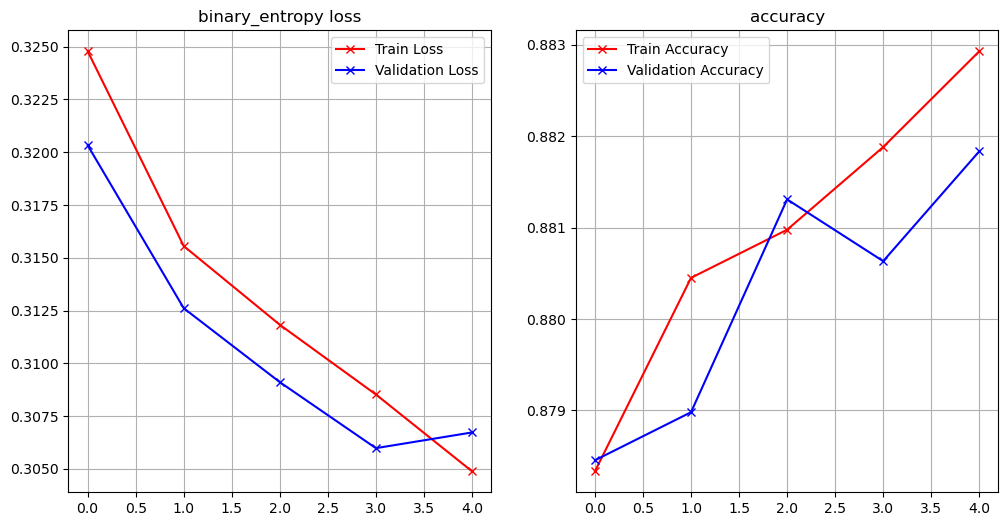

In [89]:
def plot_loss_accuracy(history):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history["loss"],'r-x', label="Train Loss")
    ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
    ax.legend()
    ax.set_title('binary_entropy loss')
    ax.grid(True)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history["binary_accuracy"],'r-x', label="Train Accuracy")
    ax.plot(history.history["val_binary_accuracy"],'b-x', label="Validation Accuracy")
    ax.legend()
    ax.set_title('accuracy')
    ax.grid(True)


plot_loss_accuracy(history)

In [ ]:
The second graph unfortunately was not able to reach the required accuracy in the given timeframe. However, give more time to train and with a larger 
epovh, this model might give a higher accuracy as it increases in every epoch.